In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))


TF Version:  2.19.0
TF-Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  []


In [2]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

def resize_image_to_square(image_np, image_size=(256,256), preserve_aspect_ratio=True):
    image_np_extra = image_np.astype(np.float32)[np.newaxis, ...]
    if image_np_extra.max() > 1.0:
        image_np_extra = image_np_extra / 255.
    if len(image_np_extra.shape) == 3:
      image_np_extra = tf.stack([image_np_extra, image_np_extra, image_np_extra], axis=-1)
    image_np_extra = crop_center(image_np_extra)
    image_np_extra = tf.image.resize(image_np_extra, image_size, preserve_aspect_ratio=True)
    return image_np_extra

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

In [3]:
import kagglehub
hub_module = hub.load(r"C:\Users\KIIT\.cache\kagglehub\models\google\arbitrary-image-stylization-v1\tensorFlow1\256\2")

C:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
content_urls = dict(
  fog='https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Fog_on_Ewell_Road%2C_Surbiton_-_geograph.org.uk_-_4727518.jpg/640px-Fog_on_Ewell_Road%2C_Surbiton_-_geograph.org.uk_-_4727518.jpg',
  fog_1='https://upload.wikimedia.org/wikipedia/commons/thumb/a/ac/Car_Light_Through_Fog.jpg/640px-Car_Light_Through_Fog.jpg' 
)

style_urls = dict(
   style_1='https://5.imimg.com/data5/SELLER/Default/2023/4/297913298/AS/KI/FW/998909/grey-canvas-fabric.webp',
   style_2='https://img.freepik.com/free-photo/gray-smooth-textured-paper-background_53876-101833.jpg',
   style_3='https://5.imimg.com/data5/SELLER/Default/2021/4/JF/ZX/RC/9847281/dark-camouflage-grey-is-629-qd-paint-1k-qd-paint-glossy-finish-indokote-500x500.png',
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}


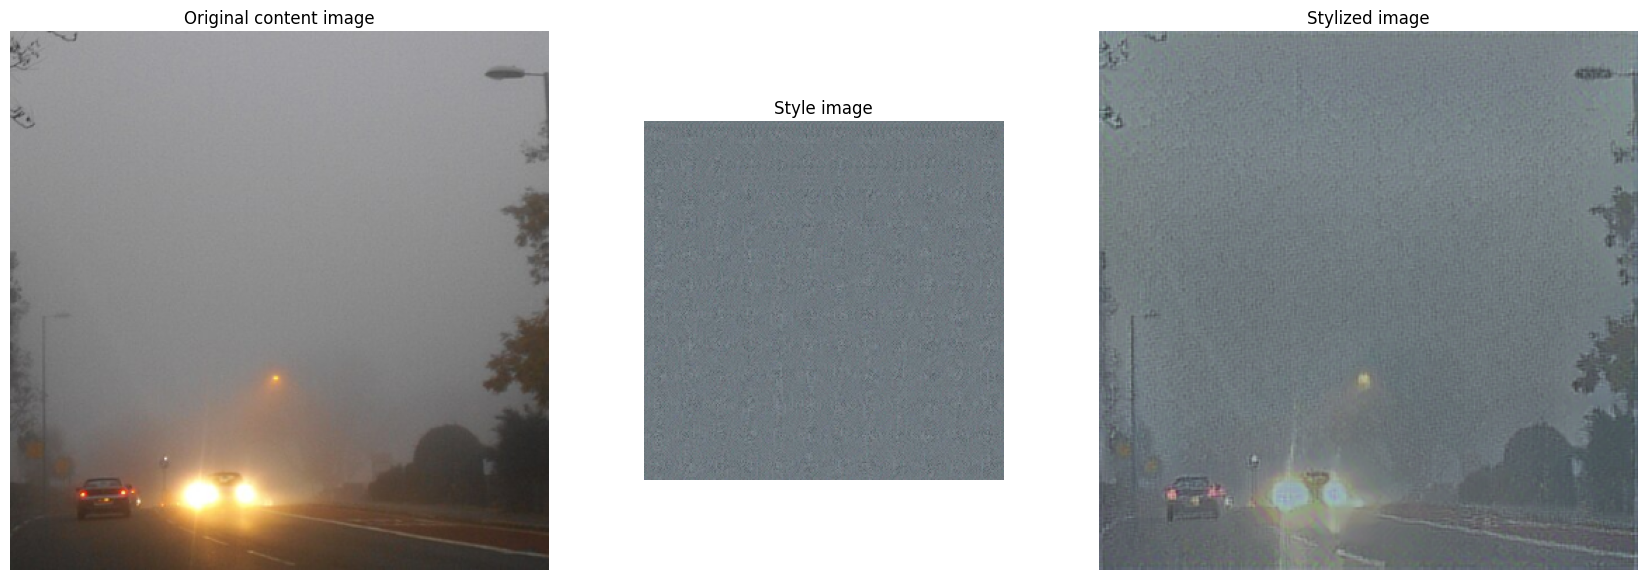

In [7]:
content_name = 'fog'  
style_name = 'style_3'  
stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

In [5]:
import cv2
from tensorflow.keras.preprocessing.image import array_to_img

def remove_dead_pixels(frame):
    if frame.dtype != np.uint8:
        frame = frame.astype(np.uint8)
    
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    mask[np.any(frame == 0, axis=-1)] = 255
    mask[np.any(frame == 255, axis=-1)] = 255
    
    frame = cv2.inpaint(frame, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return frame

def resize_image_to_square(image, image_size=(1024, 1024)):
    return cv2.resize(image, image_size)

def enhance_colors(frame):
    # Convert to LAB color space
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    
    # Merge channels and convert back to BGR
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_frame = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    return enhanced_frame

cap = cv2.VideoCapture(r"C:\Users\KIIT\Desktop\New folder\NST\New folder\videoplayback.webm")
frame_size = 1024

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(r"C:\Users\KIIT\Desktop\New folder\NST\clear_2_1_1.mp4", fourcc, 60.0, (frame_size, frame_size))
style_name = "style_2"

prev_gray = None
warp_matrix = np.eye(2, 3, dtype=np.float32)

counter = 0
while True:
    print(f"Processing Frame: {counter}")
    
    flag, frame = cap.read()
    if not flag:
        break  
    
    frame = remove_dead_pixels(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if prev_gray is not None:
        try:
            cc, warp_matrix = cv2.findTransformECC(prev_gray, gray, warp_matrix, cv2.MOTION_EUCLIDEAN)
            stabilized_frame = cv2.warpAffine(frame, warp_matrix, (frame.shape[1], frame.shape[0]), flags=cv2.INTER_LINEAR)
        except cv2.error:
            stabilized_frame = frame  
    else:
        stabilized_frame = frame
    
    prev_gray = gray.copy()
    image_rgb_np = cv2.cvtColor(stabilized_frame, cv2.COLOR_BGR2RGB)
    resized_image_np = resize_image_to_square(image_rgb_np, image_size=(frame_size, frame_size))
    resized_image_np = np.array(resized_image_np, dtype=np.float32) / 255.0
    
    input_tensor = tf.expand_dims(resized_image_np, axis=0)
    outputs = hub_module(input_tensor, tf.constant(style_images[style_name]))
    stylized_image = outputs[0]
    image_pil = array_to_img(stylized_image[0])
    
    image_bgr_np = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    enhanced_frame = enhance_colors(image_bgr_np)
    
    out.write(enhanced_frame.astype(np.uint8))  
    counter += 1

print("Processing Complete!")
out.release()
cap.release()


Processing Frame: 0
Processing Frame: 1
Processing Frame: 2
Processing Frame: 3
Processing Frame: 4
Processing Frame: 5
Processing Frame: 6
Processing Frame: 7
Processing Frame: 8
Processing Frame: 9
Processing Frame: 10
Processing Frame: 11
Processing Frame: 12
Processing Frame: 13
Processing Frame: 14
Processing Frame: 15
Processing Frame: 16
Processing Frame: 17
Processing Frame: 18
Processing Frame: 19
Processing Frame: 20
Processing Frame: 21
Processing Frame: 22
Processing Frame: 23
Processing Frame: 24
Processing Frame: 25
Processing Frame: 26
Processing Frame: 27
Processing Frame: 28
Processing Frame: 29
Processing Frame: 30
Processing Frame: 31
Processing Frame: 32
Processing Frame: 33
Processing Frame: 34
Processing Frame: 35
Processing Frame: 36
Processing Frame: 37
Processing Frame: 38
Processing Frame: 39
Processing Frame: 40
Processing Frame: 41
Processing Frame: 42
Processing Frame: 43
Processing Frame: 44
Processing Frame: 45
Processing Frame: 46
Processing Frame: 47
Pr